# Predicting numbers from raw audio waveforms
## Training a temporal convolutional neural network
In this notebook we will analyzing audio recordings from the spoken digits dataset.

A detailed description of the **Free Spoken Digit Dataset (FSDD)** dataset can be found [here](https://github.com/Jakobovski/free-spoken-digit-dataset)

For this exercise, we will use a network architecture inspired by the so called "Temporal Convolutional Network" (TCN) that was proposed in [An Empirical Evaluation of Generic Convolutional and Recurrent Networks for Sequence Modeling](https://arxiv.org/pdf/1803.01271.pdf) by Bai et al. developed with Tensorflow.

TCN are well suited to work with very long input sequences such as raw audio waveforms.

In [ ]:
import pandas as pd
import numpy as np
import librosa
import librosa.display
import tqdm
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tensorflow_datasets as tfds
from pathlib import Path

import IPython
from IPython.display import Audio

from sklearn import metrics

from sklearn.model_selection import train_test_split


## Preparing the **Free Spoken Digit Dataset (FSDD)**

In [ ]:
!git clone https://github.com/Jakobovski/free-spoken-digit-dataset.git

fatal: destination path 'free-spoken-digit-dataset' already exists and is not an empty directory.


#### Loading the metadata from the filesystem
First we will be loading the dataset metainformation into memory. 

By splitting the filename we can derive the required information.
Files are named in the following format: `{digitLabel}_{speakerName}_{index}.wav` Example: `7_jackson_32.wav`



In [ ]:
def load_metadata(root_dir='free-spoken-digit-dataset'):
    recordings_path = Path(root_dir) / 'recordings'
    data = []
    for path in recordings_path.glob('*.wav'):
      data.append((str(path), *path.stem.split('_')))

    df = pd.DataFrame(data, columns=['path', 'label', 'speaker', 'iteration'])
    df.label = df.label.apply(int)
    return df

In [ ]:
metadata = load_metadata()
metadata.head()

,path,label,speaker,iteration
0,free-spoken-digit-dataset/recordings/2_jackson...,2,jackson,15
1,free-spoken-digit-dataset/recordings/2_george_...,2,george,25
2,free-spoken-digit-dataset/recordings/5_nicolas...,5,nicolas,27
3,free-spoken-digit-dataset/recordings/0_lucas_4...,0,lucas,47
4,free-spoken-digit-dataset/recordings/3_theo_14...,3,theo,14


In [ ]:
SAMPLING_RATE=16_000
MAX_DURATION_S=0.5

#### Loading the audio waveform from the filesystem
Next we use librosa to load the waveform from the filesystem and convert the loaded data into `tf.data.Dataset`.

Can you derive what is happening in `load_audio`?

In [ ]:
def load_audio(path, sampling_rate=SAMPLING_RATE, duration_s=MAX_DURATION_S):
    audio = np.zeros(int(duration_s * sampling_rate))
    waveform, __ = librosa.load(path, sr=sampling_rate)
    waveform = waveform[:len(audio)]
    audio[:len(waveform)] = waveform
    return audio

def load_melspectrogram(path, sampling_rate=SAMPLING_RATE, duration_s=MAX_DURATION_S):
  waveform = load_audio(path, sampling_rate, duration_s)
  M = librosa.feature.melspectrogram(y=waveform, sr=SAMPLING_RATE)
  M_db = librosa.power_to_db(M, ref=np.max)
  return M_db

def load_mfcc(path, sampling_rate=SAMPLING_RATE, duration_s=MAX_DURATION_S):
  waveform = load_audio(path, sampling_rate, duration_s)
  mfcc = librosa.feature.mfcc(y=waveform, sr=sampling_rate)
  return mfcc

def build_tf_dataset(metadata):
    data = [load_audio(path) for path in tqdm.tqdm(metadata.path, desc='Loading audio')]
    return tf.data.Dataset.from_tensor_slices((data, metadata.label))

### Splitting the data into train and test
Now that we have loaded the required metadata into memory we have to split the dataset into train and test. We want 75% of the data to be in the training and 25% in the test set

**NOTE:** We have multiple recordings from the same speaker. To avoid that informartion is leaking from the training into the test dataset we want to make sure that each speaker either appears one or the other dataset. This is called a stratified sample split

**NOTE:** Documentation for [`train_test_split`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)

In [ ]:
##########################
## YOUR CODE HERE START ##
##########################

# Split the data into train an test
# The test size should be 25% of the entire dataset
# Ensure to perform a stratified split along the speaker

train_dataset, test_dataset, train_labels, test_labels = train_test_split(
    metadata, 
    metadata["label"], 
    random_state=1, 
    test_size=0.25, 
    shuffle=True,
    stratify=metadata['speaker']
)

##########################
## YOUR CODE HERE END ##
##########################

print(f"Train set: {len(train_dataset)}\nTest set: {len(test_dataset)}")

Train set: 2250
Test set: 750


In [ ]:
train_tf_dataset = build_tf_dataset(train_dataset)
test_tf_dataset = build_tf_dataset(test_dataset)

Loading audio: 100%|██████████| 750/750 [00:09<00:00, 81.04it/s]


### Visualizing the dataset
Now that we have converted the input data into a Tensorflow dataset we want to visualize the data to get a better intuition.

Do you see how the amplitudes in the raw audiowaveform are being represented in the spectograms?

In [ ]:
def visualize_audio(audio, label, sr=SAMPLING_RATE):
  fig, ax = plt.subplots(1, 4, figsize=(20, 4))
  fig.suptitle(f'Label {label}')
  duration = len(audio) / sr
  t = np.linspace(0, duration, len(audio))
  ax[0].plot(t, audio)
  ax[0].set_title('waveform')
  ax[0].set_xlabel('Time')

  D = librosa.stft(audio)  # STFT of y
  S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
  ax[1].set(title='Spectogram display')
  img = librosa.display.specshow(S_db, x_axis='time', y_axis='log', ax=ax[1])
  fig.colorbar(img, ax=ax[1], format="%+2.f dB")

  M = librosa.feature.melspectrogram(y=audio, sr=sr)
  M_db = librosa.power_to_db(M, ref=np.max)
  img = librosa.display.specshow(M_db, y_axis='mel', x_axis='time', ax=ax[2])
  ax[2].set(title='Mel spectrogram display')
  fig.colorbar(img, ax=ax[2], format="%+2.f dB")

  mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40)
  img = librosa.display.specshow(mfcc, y_axis='mel', x_axis='time', ax=ax[3])
  ax[3].set(title='Mel Frequency Cepstral Coefficients')
  fig.colorbar(img, ax=ax[3])
  IPython.display.display(Audio(data=audio, rate=sr, embed=True))

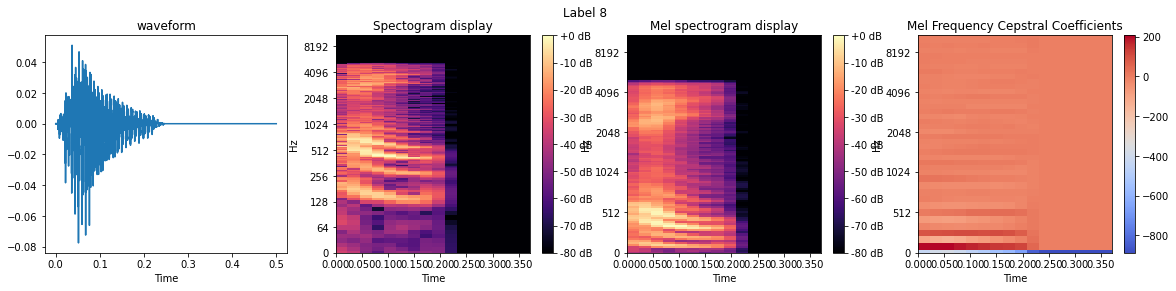

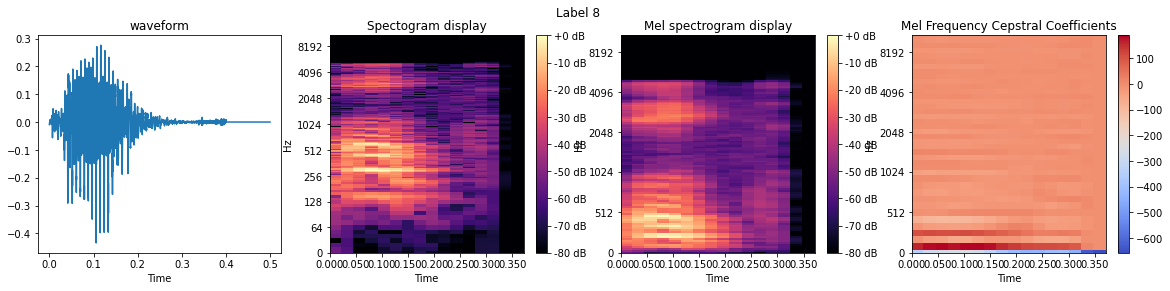

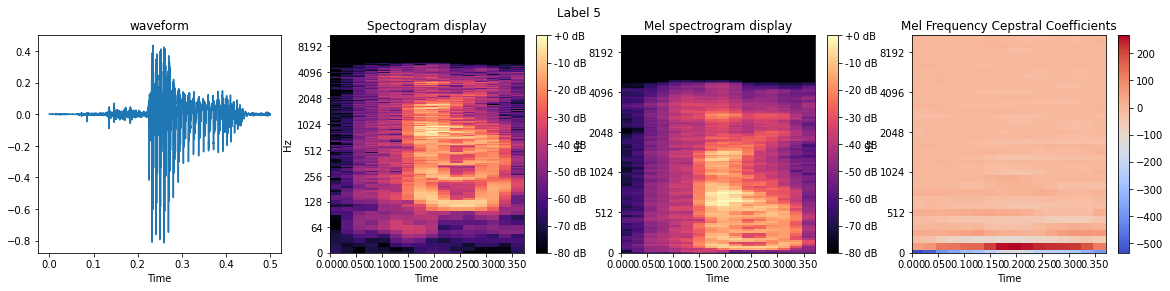

In [ ]:
##########################
## YOUR CODE HERE START ##
##########################

for (audio, label) in train_tf_dataset.take(3):

    # pass in the waveform and the corresponding label
    visualize_audio(audio.numpy(), label.numpy())

##########################
## YOUR CODE HERE END ##
##########################

In [ ]:
BATCH_SIZE = 16
EPOCHS = 20

In [ ]:
train_tf_dataset = (train_tf_dataset
                    .shuffle(buffer_size=len(train_dataset), reshuffle_each_iteration=True)
                    .repeat(EPOCHS)
                    .batch(BATCH_SIZE))

test_tf_dataset = (test_tf_dataset
                    .batch(BATCH_SIZE))

## Model creation
Here we build our model using a TCN model.
We will be using the raw audio waveform as input into a simple TCNN-stack. The last layer will translate the hidden states into mutli-class probabilities bewtween 0 and 1.

For the TCN model you will use a simple architecture composed of a stack of  convolutional and maxpooling layers connected to a fully connected output with 10 units since there are 10 categories.

In a proper TCN model we would ensure that the receptive field size of the model is large enough to caputre the entire input sequence and then we would select a particular entry of the resulting feature map. Here, for simplicity we build a stack of convolutions and maxpooling and flatten the resulting feature map to feed it into our dense layer.
 
Define the model using Keras' [Functional API](https://keras.io/guides/functional_api/):
 
**NOTE:** Documentation for [Conv1D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv1D), [MaxPool1D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool1D), [Flatten](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten), [Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) layer
 

**NOTE**: This is a multi-class classification problem. Think about the correct activation function for this kind of problem.

**NOTE**: we want to exponentially increase the `dilation_rate` of the Conv1D with increasing depth (1, 2, 4, 8...)



In [ ]:
def build_model(max_len=int(SAMPLING_RATE * MAX_DURATION_S)):
    """ add binary classification to pretrained model
    """

    inputs = tf.keras.layers.Input(
        shape=(max_len, 1), dtype=tf.float32, name="inputs"
    )

    ##########################
    ## YOUR CODE HERE START ##
    ##########################
    
    # build a TCN classification stack 
    # on top of the raw inputs

    # experiment with different depth and see how it affects the number of params
    # and the performance of the model

    depth = 8
    stack = inputs
    for i in range(depth):
        # exponentially increase the dilation_rate
        dilation_rate = 2 ** i

        # define the 1D convolution with 25 filte and a kernel size of 8
        # use the dilation rate defined above
        # make sure to use causal convolutions
        stack = tf.keras.layers.Conv1D(filters=25, 
                                       kernel_size=8, 
                                       dilation_rate=dilation_rate, 
                                       padding='causal')(stack)

        # Reduce the size of the feature map using max pooling
        stack = tf.keras.layers.MaxPool1D()(stack)

        # Use an activation function on top of the resulting feature map
        stack = tf.keras.layers.Activation('relu')(stack)

    stack = tf.keras.layers.Flatten()(stack)
    output = tf.keras.layers.Dense(10, activation='softmax')(stack)

    ##########################
    ## YOUR CODE HERE END ##
    ##########################

    model = tf.keras.models.Model(inputs=inputs, outputs=output)
    
    return model

In [ ]:
model = build_model()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 8000, 1)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 8000, 25)          225       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 4000, 25)          0         
_________________________________________________________________
activation (Activation)      (None, 4000, 25)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 4000, 25)          5025      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 2000, 25)          0         
_________________________________________________________________
activation_1 (Activation)    (None, 2000, 25)          0     

#### Finalizing the model
Now that we successfully created our model, we have to finalize it by defining the loss that has to be minimized and which optimizier we want to use.

The Tensorflow documentation lists all available [losses](https://www.tensorflow.org/api_docs/python/tf/keras/losses) and [optimizers](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers) you should choose from.

**NOTE**: This is a multi-class classification problem. Think about the correct loss function for this kind of problem.

**NOTE**: Make sure to initialize your optimizer with the learning rate that was defined above.

In [ ]:
##########################
## YOUR CODE HERE START ##
##########################


LEARNING_RATE = 1e-3

# Create an instance of an Adam optimizer with the learning rate defined above 
# Define the loss to be minimized in this classification problem
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
loss = "sparse_categorical_crossentropy"

model.compile(optimizer, loss=loss, metrics=["sparse_categorical_accuracy"])

##########################
## YOUR CODE HERE END ##
##########################

## Model training
Now we are ready to train model on our dataset
We will be monitoring the training process using tensorboard. Once the training is launche you will be able to inspect logged metrics (under scalars) and track the the progress. 

In the graph section you can look at a visual representation of your model. Can you find your classification stack in the graph?

In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs

In [ ]:
hist = model.fit(
    train_tf_dataset,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    steps_per_epoch=int(np.floor((len(train_dataset) / BATCH_SIZE))),
    validation_data=test_tf_dataset,
    verbose=1,
    callbacks=[
               tf.keras.callbacks.EarlyStopping(monitor="val_loss", verbose=1, patience=1, restore_best_weights=True),
               tf.keras.callbacks.TensorBoard(f'logs/{datetime.now()}')
               ],
)

Epoch 1/20
140/140 [==============================] - 7s 37ms/step - loss: 2.1576 - sparse_categorical_accuracy: 0.1705 - val_loss: 1.9043 - val_sparse_categorical_accuracy: 0.2520
Epoch 2/20
140/140 [==============================] - 4s 32ms/step - loss: 1.6573 - sparse_categorical_accuracy: 0.3536 - val_loss: 1.5656 - val_sparse_categorical_accuracy: 0.3813
Epoch 3/20
140/140 [==============================] - 4s 30ms/step - loss: 1.4461 - sparse_categorical_accuracy: 0.4321 - val_loss: 1.3881 - val_sparse_categorical_accuracy: 0.4707
Epoch 4/20
140/140 [==============================] - 4s 30ms/step - loss: 1.3023 - sparse_categorical_accuracy: 0.4946 - val_loss: 1.2140 - val_sparse_categorical_accuracy: 0.5213
Epoch 5/20
140/140 [==============================] - 4s 30ms/step - loss: 1.1622 - sparse_categorical_accuracy: 0.5397 - val_loss: 1.1578 - val_sparse_categorical_accuracy: 0.5347
Epoch 6/20
140/140 [==============================] - 4s 30ms/step - loss: 1.0111 - sparse_cate

### Training metrics
Lets inspect the training history to see how the losses and metrics behaved during training

In [ ]:
history = pd.DataFrame({'epoch': hist.epoch, **hist.history}).set_index('epoch')
history

,loss,sparse_categorical_accuracy,val_loss,val_sparse_categorical_accuracy
epoch,,,,
0,2.157563,0.170536,1.904330,0.252000
1,1.657289,0.353571,1.565594,0.381333
2,1.446118,0.432143,1.388053,0.470667
3,1.302285,0.494643,1.213981,0.521333
4,1.162212,0.539732,1.157765,0.534667
5,1.011125,0.594643,1.061847,0.613333
6,0.909139,0.640179,0.914068,0.652000
7,0.819410,0.690179,0.834041,0.670667
8,0.683680,0.744643,0.752714,0.733333


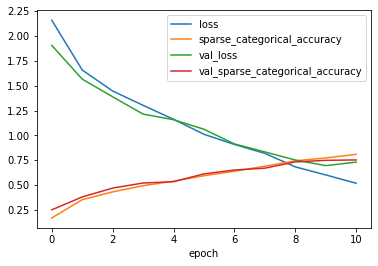

In [ ]:
history.plot()

## Model evaluation
Lets have a look how well the model is preforming on our test dataset.

In [ ]:
predictions = model.predict(test_tf_dataset, batch_size=BATCH_SIZE, verbose=2, use_multiprocessing=True)

47/47 - 1s


In [ ]:
report = metrics.classification_report(y_true=test_labels, 
                                       y_pred=predictions.argmax(axis=1))
print(report)

              precision    recall  f1-score   support

           0       1.00      0.96      0.98        85
           1       0.73      0.85      0.79        62
           2       0.65      0.58      0.61        92
           3       0.59      0.54      0.56        78
           4       0.76      0.86      0.81        64
           5       0.81      0.76      0.79        80
           6       0.58      0.88      0.70        72
           7       0.83      0.76      0.79        63
           8       0.89      0.72      0.80        82
           9       0.72      0.64      0.68        72

    accuracy                           0.75       750
   macro avg       0.76      0.76      0.75       750
weighted avg       0.76      0.75      0.75       750

